# Импорт библиотек

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
import torch
import torchvision.transforms as transforms
import cv2
from PIL import Image
from sklearn.linear_model import LinearRegression
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve
import scipy.signal as signal
import random
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

# Задание окружения

In [2]:
figures = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))), "2023-Project-112", "figures")

# Работа с данными

## Видеоряд

In [3]:
video_path = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))), "src", "Film stimulus.mp4")

In [4]:
def video_to_frames():
    videocap = cv2.VideoCapture(video_path)
    success, frame = videocap.read()
    count = 1
    while success:
        cv2.imwrite(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),
                                "src", "frames", f"frame_{count}.jpg"), frame)    
        success, frame = videocap.read()
        count += 1

In [5]:
frame_path = os.path.join(os.path.dirname(os.getcwd()), "2023-Project-112", "src", "frames", f"frame_{1}.jpg")
frame = Image.open(frame_path)

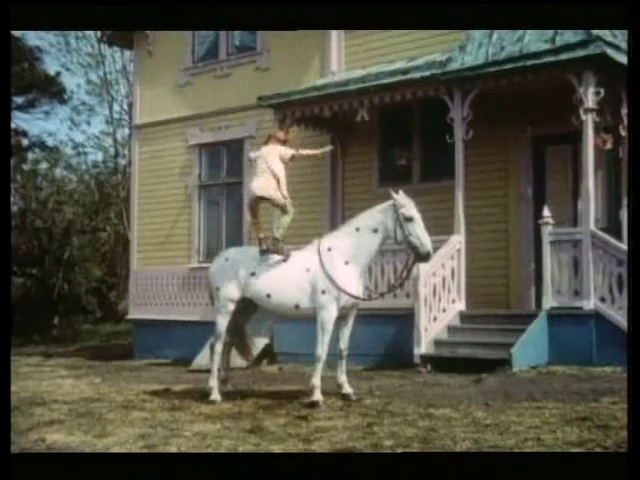

In [6]:
frame

In [7]:
transformer = transforms.ToTensor()
np_tensor = transformer(frame).numpy()
d1, d2, d3 = np_tensor.shape 
transformer(frame).numpy().reshape(d1 * d2 * d3)

array([0.00392157, 0.00392157, 0.00392157, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [8]:
#video_to_frames()

In [9]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True, verbose=False)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(2048, 2048)

c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\kisnikser\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
def frames_to_tensors():
    for i in range(1, 9751):
        frame_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "src", "frames", f"frame_{i}.jpg")
        frame = Image.open(frame_path)
        frame_tensor = preprocess(frame)
        frame_tensor = frame_tensor.unsqueeze(0)
        yield frame_tensor

In [10]:
# меняем frames_to_tensors()

def frames_to_tensors():
    for i in range(1, 9751):
        frame_path = os.path.join(os.path.dirname(os.getcwd()), "2023-Project-112", "src", "frames", f"frame_{i}.jpg")
        frame = Image.open(frame_path)
        transformer = transforms.ToTensor()
        frame_tensor = transformer(frame)
        yield frame_tensor

In [11]:
def tensors_to_vectors():
    for frame_tensor in frames_to_tensors():
        # передача картинки в модель и получение выходных данных
        with torch.no_grad():
            output = model(frame_tensor)
        # преобразование выходных данных в вектор
        vector = output.numpy().flatten()
        yield vector

In [12]:
# меняем tensors_to_vectors()

def tensors_to_vectors():
    for frame_tensor in frames_to_tensors():
        vector = frame_tensor.numpy().flatten()
        yield vector

In [14]:
vector_list = [vector for vector in tensors_to_vectors()]

## Снимки фМРТ

In [15]:
class Sub:

    subs_with_fmri = ['04', '07', '08', '09', '11', '13', '14', '15', '16', '18',\
                  '22', '24', '27', '28', '29', '31', '35', '41', '43', '44',\
                  '45', '46', '47', '51', '52', '53', '55', '56', '60', '62']

    def __init__(self, number):
        if not number in Sub.subs_with_fmri:
            raise ValueError(f"У {number} испытуемого отсутствуют снимки фМРТ")
        else:
            self.number = number
        self.path = os.path.join(os.path.dirname(os.getcwd()), "2023-Project-112", "src", "ds003688-download", f"sub-{self.number}",\
                                    "ses-mri3t", "func", f"sub-{self.number}_ses-mri3t_task-film_run-1_bold.nii.gz")
        self.scan = nib.load(self.path)
        self.data = self.scan.get_fdata()
        self.tensor = torch.tensor(self.data)
        self.tensor_np = self.tensor.numpy()

# Построение линейной модели

In [16]:
class Preprocessor:

    def __init__(self, sub, dt, coef, train_size=0.7):
        self.sub = sub
        self.dt = dt
        self.coef = coef
        self.train_size = train_size

        self.nu = 25 # частота видео
        self.mu = 641. / 390. # частота снимков фМРТ
        self.d1 = self.sub.tensor.shape[0] # размерности снимка фМРТ до сжатия
        self.d2 = self.sub.tensor.shape[1]
        self.d3 = self.sub.tensor.shape[2]
        self.d4 = self.sub.tensor.shape[3]
        self.d = 2048 # длина вектора признакового описания изображения
        self.N = 641 - int(self.mu * self.dt) # N - количество снимков фМРТ

        self.train, self.test = self.get_train_test()

    @staticmethod
    def preprocess(v):
        return (v - v.min()) / (v.max() - v.min())

    @staticmethod
    def MSE(A):
        m, n = A.shape
        return (np.linalg.norm(A, "fro") ** 2) / (m * n)

    def get_train_test(self):
        pairs = [(int(i * self.nu / self.mu), int(self.mu * self.dt + i)) for i in range(self.N)] # (номер изображения, номер снимка)

        if (self.coef > 1): # сжатие снимка фМРТ
            maxpool = torch.nn.MaxPool3d(kernel_size=self.coef, stride=self.coef)
            input_tensor = self.sub.tensor.permute(3, 0, 1, 2)
            output_tensor = maxpool(input_tensor).permute(1, 2, 3, 0)
            self.sub._tensor = output_tensor
        else:
            self.sub._tensor = self.sub.tensor
        
        self._d1 = self.sub._tensor.shape[0]
        self._d2 = self.sub._tensor.shape[1]
        self._d3 = self.sub._tensor.shape[2]
        self._d4 = self.sub._tensor.shape[3]
        
        scans_list = [self.sub._tensor[:, :, :, i] for i in range(self.d4)] # список тензоров снимков фМРТ
        voxels = [scan.reshape(self._d1 * self._d2 * self._d3).numpy() for scan in scans_list] # список снимков фМРТ, развернутых в векторы
        data = [(vector_list[n], voxels[k]) for n, k in pairs] # (изображение, снимок)

        # train, test
        l = int(self.train_size * self.d4) # размер обучающей выборки
        train, test = data[:l], data[l:]
            
        train = [(pair[0], self.preprocess(pair[1])) for pair in train]
        test = [(pair[0], self.preprocess(pair[1])) for pair in test]

        return train, test
    

## Предсказание снимка

In [17]:
class LinearPredictor(Preprocessor):
    
    def __init__(self, sub, dt, coef, alpha, train_size=0.7):
        super().__init__(sub, dt, coef, train_size)
        self.delta = False
        self.alpha = alpha
        self.X_train, self.Y_train, self.X_test, self.Y_test = self.get_XY()

    def get_XY(self):
        X_train = np.array([pair[0] for pair in self.train])
        Y_train = np.array([pair[1] for pair in self.train]).T
        X_test = np.array([pair[0] for pair in self.test])
        Y_test = np.array([pair[1] for pair in self.test]).T
        return X_train, Y_train, X_test, Y_test

    def predict(self):
        W = [] # матрица весов модели

        if (self.alpha > 0):
            A = np.linalg.inv(self.X_train.T @ self.X_train + self.alpha * np.identity(self.X_train.shape[1])) @ self.X_train.T
        else:
            A = np.linalg.pinv(self.X_train)
        
        for i in range(self._d1 * self._d2 * self._d3):
            Y_train_vector = self.Y_train[i]
            w = A @ Y_train_vector
            W.append(w)
            
        self.W = np.array(W) # w будут строками

        self.Y_train_predicted = self.W @ self.X_train.T
        self.Y_test_predicted = self.W @ self.X_test.T

        self.MSE_train = self.MSE(self.Y_train_predicted - self.Y_train)
        self.MSE_test = self.MSE(self.Y_test_predicted - self.Y_test)

## Предсказание разницы между снимками

In [18]:
class LinearDeltaPredictor(Preprocessor):
    def __init__(self, sub, dt, coef, alpha, train_size=0.7):
        super().__init__(sub, dt, coef, train_size)
        self.delta = True
        self.alpha = alpha
        self.X_train, self.Y_train, self.deltaY_train, self.X_test, self.Y_test, self.deltaY_test = self.get_XY()

    def get_XY(self):
        delta_train = [(self.train[n][0], self.train[n][1] - self.train[n-1][1]) for n in range(1, len(self.train))]
        delta_test = [(self.test[n][0], self.test[n][1] - self.test[n-1][1]) for n in range(1, len(self.test))]
        Y_train = np.array([pair[1] for pair in self.train]).T
        Y_test = np.array([pair[1] for pair in self.test]).T
        X_train = np.array([pair[0] for pair in delta_train])
        deltaY_train = np.array([pair[1] for pair in delta_train]).T
        X_test = np.array([pair[0] for pair in delta_test])
        deltaY_test = np.array([pair[1] for pair in delta_test]).T
        return X_train, Y_train, deltaY_train, X_test, Y_test, deltaY_test

    def predict(self):
        W = [] # матрица весов модели

        if (self.alpha > 0):
            A = np.linalg.inv(self.X_train.T @ self.X_train + self.alpha * np.identity(self.X_train.shape[1])) @ self.X_train.T
        else:
            A = np.linalg.pinv(self.X_train)
        
        for i in range(self._d1 * self._d2 * self._d3):
            deltaY_train_vector = self.deltaY_train[i]
            w = A @ deltaY_train_vector
            W.append(w)
            
        self.W = np.array(W) # w будут строками

        self.deltaY_train_predicted = self.W @ self.X_train.T
        self.deltaY_test_predicted = self.W @ self.X_test.T
        self.Y_train_predicted = np.delete(self.Y_train, -1, 1) + self.deltaY_train_predicted
        self.Y_test_predicted = np.delete(self.Y_test, -1, 1) + self.deltaY_test_predicted
    
        self.MSE_train = self.MSE(self.Y_train_predicted - np.delete(self.Y_train, 0, 1))
        self.MSE_test = self.MSE(self.Y_test_predicted - np.delete(self.Y_test, 0, 1))

# Пример работы

In [19]:
sub = Sub('04')

In [20]:
lindeltapred = LinearDeltaPredictor(sub, 5, 1, 0)

In [21]:
lindeltapred.X_train.shape

(447, 921600)

In [22]:
lindeltapred.Y_train.shape

(163840, 448)

$$
\begin{aligned}
    X &= \mathrm{X\_train} \\
    y &= \mathrm{deltaY\_train\_vector} \\
    f(w) &= \| Xw - y \|_2^2 \\
    \nabla f(w) &= 2 X^\top (Xw - y) \\
    \nabla^2 f(w) &= 2 X^\top X
\end{aligned}


In [23]:
X = lindeltapred.X_train
y = lindeltapred.deltaY_train[307]
w = np.zeros(X.shape[1])

In [26]:
np.linalg.matrix_rank(X)

9

In [67]:
def f(w):
    return np.linalg.norm(X @ w - y) ** 2

In [68]:
def df(w):
    return 2 * X.T @ (X @ w - y)

In [69]:
def d2f(w):
    return 2 * X.T @ X

In [36]:
d2f(w)

MemoryError: Unable to allocate 3.09 TiB for an array with shape (921600, 921600) and data type float32

ПРОБЛЕМА! Несмотря на то, что задача, очевидно, является $L$-гладкой, найти точное значение $L$ не представляется возможным.

---

#### Градиентный спуск с постоянным шагом

In [86]:
def GD(w0, h=1e-2, df_eps=1e-6, max_iter=1000):
    df_log = []
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    while df_log[-1] > df_eps and len(df_log) <= max_iter:
        w = w - h * df(w)
        df_log.append(np.linalg.norm(df(w)))
    return w, df_log

In [88]:
w0 = np.zeros(X.shape[1])
w_GD, df_log_GD = GD(w0, h=1e-6)

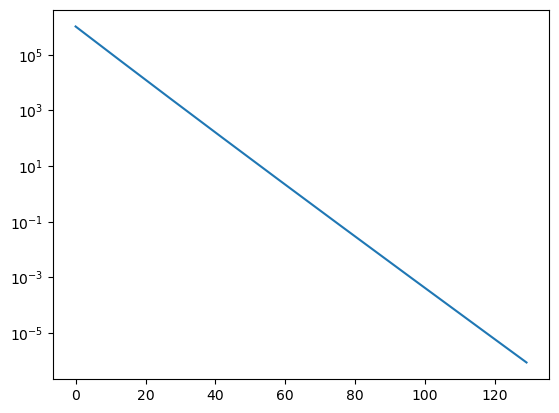

In [89]:
plt.plot(df_log_GD)
plt.yscale('log')

---

#### Градиентный спуск с подбором шага по правилу Армихо

In [90]:
def Armijo(w, h0=1, alpha=0.3, rho=0.5):
    h = h0
    g = df(w)
    while f(w - h * g) > f(w) - alpha * h * g.T @ df(w):
        h = rho * h
    return h

In [91]:
def GD_Armijo(w0, df_eps=1e-6, max_iter=1000):
    df_log = []
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    while df_log[-1] > df_eps and len(df_log) <= max_iter:
        h = Armijo(w)
        w = w - h * df(w)
        df_log.append(np.linalg.norm(df(w)))
    return w, df_log

In [92]:
w0 = np.zeros(X.shape[1])
w_GD_Armijo, df_log_GD_Armijo = GD_Armijo(w0)

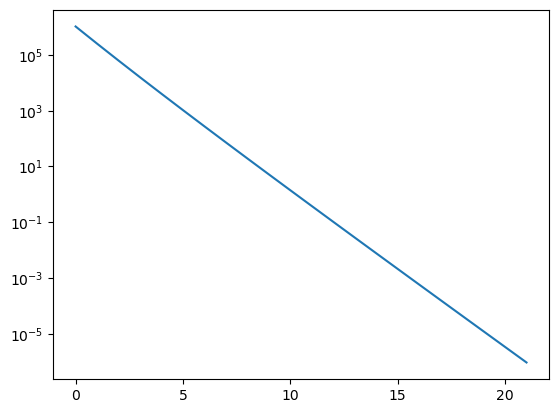

In [93]:
plt.plot(df_log_GD_Armijo)
plt.yscale('log')

---

#### Стохастический градиентный спуск

In [94]:
def SGD(w0, h=1e-6, df_eps=1e-6, max_iter=1000):
    df_log = []
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    n_samples, n_features = X.shape
    while df_log[-1] > df_eps and len(df_log) <= max_iter:
        i = np.random.randint(n_samples)
        g = 2 * X[i] * (X[i] @ w - y[i])
        w = w - h * g
        df_log.append(np.linalg.norm(df(w)))
    return w, df_log

In [101]:
w0 = np.zeros(X.shape[1])
w_SGD, df_log_SGD = SGD(w0, h=1e-6)

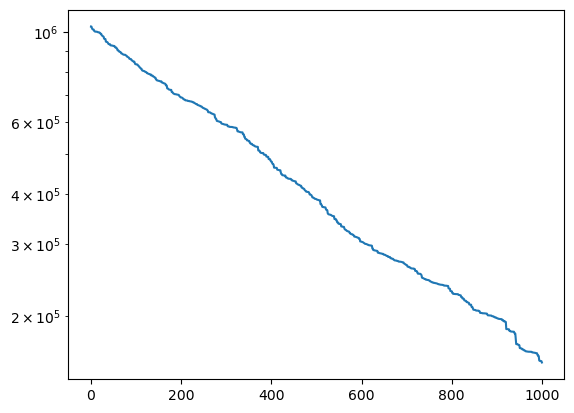

In [102]:
plt.plot(df_log_SGD)
plt.yscale('log')

---

#### Momentum

In [103]:
def Momentum(w0, alpha=1e-3, beta=0.9, max_iter=1000):
    df_log = []
    v = np.zeros(len(w0))
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    for _ in range(max_iter):
        v = beta * v - alpha * df(w)
        w = w + v
        df_log.append(np.linalg.norm(df(w)))
    return w, df_log

In [106]:
w0 = np.zeros(X.shape[1])
w_Momentum, df_log_Momentum = Momentum(w0, alpha=1e-8)

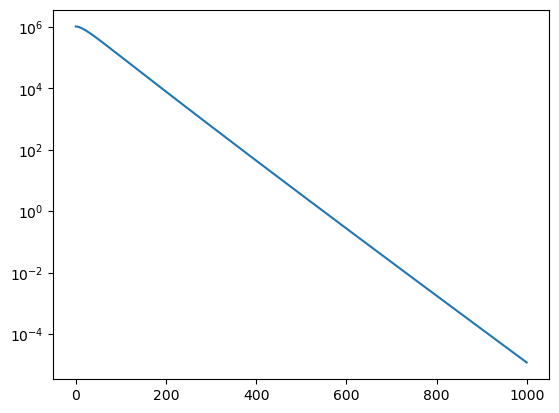

In [108]:
plt.plot(df_log_Momentum)
plt.yscale('log')

---

#### Nesterov Momentum

In [109]:
def NesterovMomentum(w0, alpha=1e-3, beta=0.9, max_iter=1000):
    df_log = []
    v = np.zeros(len(w0))
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    for _ in range(max_iter):
        v = beta * v - alpha * df(w + beta * v)
        w = w + v
        df_log.append(np.linalg.norm(df(w)))
    return w, df_log

In [110]:
w0 = np.zeros(X.shape[1])
w_NesterovMomentum, df_log_NesterovMomentum = NesterovMomentum(w0, alpha=1e-8)

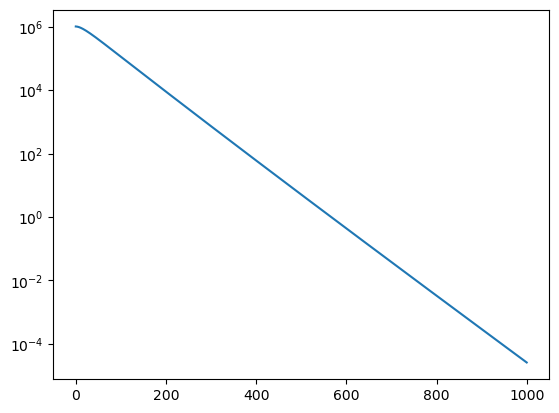

In [111]:
plt.plot(df_log_NesterovMomentum)
plt.yscale('log')

---

#### Adagrad

In [112]:
def Adagrad(w0, alpha=1e-2, eps=1e-8, max_iter=1000):
    df_log = []
    G = np.zeros(len(w0))
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    for _ in range(max_iter):
        g = df(w)
        G = G + g ** 2
        w = w - alpha / np.sqrt(G + eps) * g
        df_log.append(np.linalg.norm(g))
    return w, df_log

In [113]:
w0 = np.zeros(X.shape[1])
w_Adagrad, df_log_Adagrad = Adagrad(w0, alpha=1e-3)

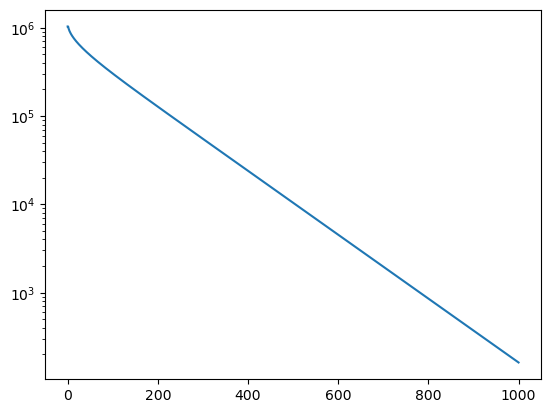

In [115]:
plt.plot(df_log_Adagrad)
plt.yscale('log')

---

#### RMSProp

In [117]:
def RMSProp(w0, alpha=1e-2, gamma=0.9, eps=1e-8, max_iter=1000):
    df_log = []
    G = np.zeros(len(w0))
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    for _ in range(max_iter):
        g = df(w)
        G = gamma * G + (1 - gamma) * g ** 2
        w = w - alpha / np.sqrt(G + eps) * g
        df_log.append(np.linalg.norm(g))
    return w, df_log

In [118]:
w0 = np.zeros(X.shape[1])
w_RMSProp, df_log_RMSProp = RMSProp(w0, alpha=1e-3)

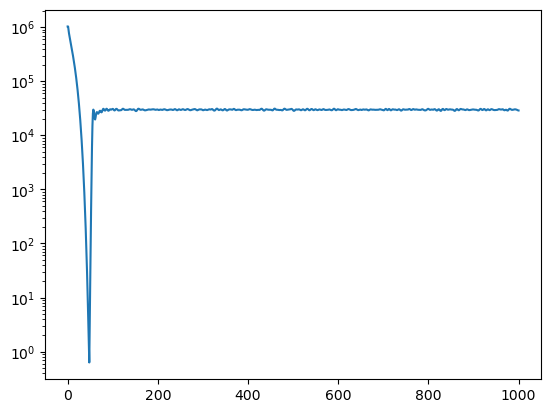

In [120]:
plt.plot(df_log_RMSProp)
plt.yscale('log')

---

#### Adam

In [121]:
def Adam(w0, alpha=1e-2, beta_1=0.9, beta_2=0.999, eps=1e-8, max_iter=1000):
    df_log = []
    v = np.zeros_like(w0)
    G = np.zeros_like(w0)
    w = np.array(w0)
    df_log.append(np.linalg.norm(df(w)))
    for i in range(1, max_iter+1):
        g = df(w)
        v = beta_1 * v + (1 - beta_1) * g
        G = beta_2 * G + (1 - beta_2) * g ** 2
        v_hat = v / (1 - beta_1 ** i)
        G_hat = G / (1 - beta_2 ** i)
        w = w - alpha / np.sqrt(G_hat + eps) * v_hat
        df_log.append(np.linalg.norm(g))
    return w, df_log

In [125]:
w0 = np.zeros(X.shape[1])
w_Adam, df_log_Adam = Adam(w0, alpha=3e-4)

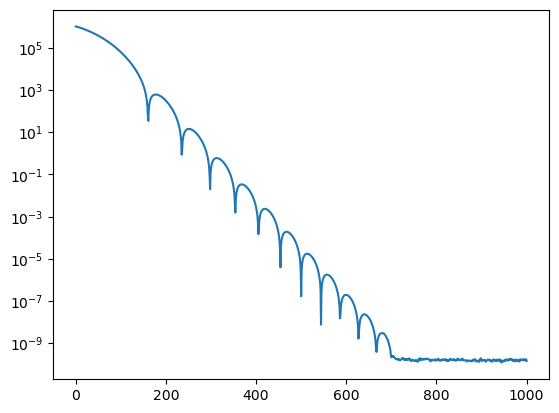

In [128]:
plt.plot(df_log_Adam)
plt.yscale('log')

---

# Toy problem

In [61]:
from sklearn.datasets import make_regression

In [62]:
X, y = make_regression(n_samples=100, n_features=100000)

In [64]:
np.linalg.matrix_rank(X)

100